In [1]:
import os
import sys
import time
import copy
import random
import argparse

from collections import OrderedDict

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision import datasets

import PIL

import matplotlib
from mpl_toolkits import mplot3d
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import seaborn as sns

from livelossplot import PlotLosses

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, classification_report

from tqdm import tqdm

sys.path.append("../src/expB/")
from spheres import RandomSphere
from ptcifar.models import *
from learn_mfld_distance import test
from myNNs import *

In [27]:
train_set = torch.load("/azuredrive/datasets/expB/one_sphere/max_norm=2,D=1,n=2/tuning/hparams_wo_neg_size/train_set.pt")
val_set = torch.load("/azuredrive/datasets/expB/one_sphere/max_norm=2,D=1,n=2/tuning/hparams_wo_neg_size/val_set.pt")



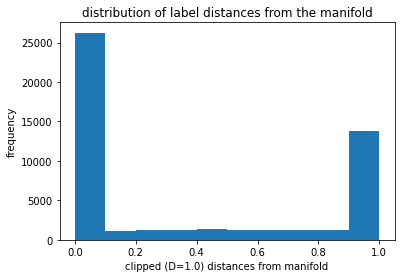

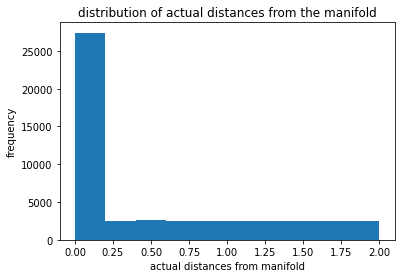

IndexError: index 2 is out of bounds for axis 1 with size 2

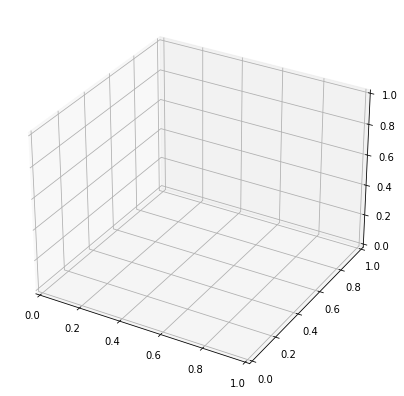

In [29]:
val_set.viz_test()



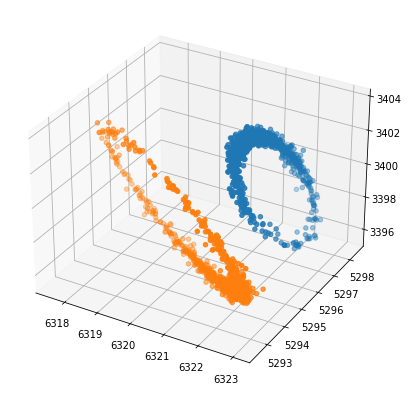

In [21]:
fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")

ax1.scatter3D(train_set.S1.points_n[:1000, 0],\
              train_set.S1.points_n[:1000:, 1], train_set.S1.points_n[:1000:, 2])

ax1.scatter3D(train_set.shifted_S2.points_n[:1000, 0],\
              train_set.shifted_S2.points_n[:1000:, 1], train_set.shifted_S2.points_n[:1000:, 2])

# plt.title("on-manifold samples (trivial embedding)")
plt.show()

In [9]:
import plotly.express as px
import pandas as pd

In [30]:
# points = np.vstack((train_set.S1.points_n[:, :3].numpy(), train_set.shifted_S2.points_n[:, :3].numpy()))
# classes = ["S1"] * train_set.S1.points_n.shape[0] + ["S2"] * train_set.S2.points_n.shape[0]

points = train_set.points_n[:, :2]
# classes = train_set.class_labels

df = pd.DataFrame(points)
df.columns = ["x", "y"]
# class_equiv = {0: "none", 1: "S1", 2: "S2"}
# df["classes"] = classes
# df["classes"] = df["classes"].map(class_equiv)

# test with any z-coordinate
# df["x"] = np.hstack((train_set.S1.points_n[:, 0].numpy(), train_set.shifted_S2.points_n[:, 0].numpy()))
# df["y"] = np.hstack((train_set.S1.points_n[:, 1].numpy(), train_set.shifted_S2.points_n[:, 1].numpy()))
# df["z"] = np.hstack((train_set.S1.points_n[:, 2].numpy(), train_set.shifted_S2.points_n[:, 2].numpy()))
px.scatter(df, x="x", y="y")

In [14]:

dataset = torch.load("/azuredrive/datasets/expB/one_sphere/max_norm=12.5,D=7.5,n=2/train_set.pt")
dataloader = DataLoader(dataset, num_workers=8, batch_size=512, shuffle=False)

# model = ResNet18(num_classes=1)
model = MLP(input_size=2, output_size=1, hidden_sizes=[512, 256, 128, 64])
model.load_state_dict(torch.load("/data/adv_geom/dumps/expB_learning_distance_from_mfld/MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}//08052021-144232/models/MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}_08052021-144232_val_loss_16.690271663665772_epoch_100.pth")["model_state_dict"])






<All keys matched successfully>

In [12]:
! ls "/data/adv_geom/dumps/expB_learning_distance_from_mfld/MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}/08052021-144232/models"




'MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}_08052021-144232_val_loss_16.690271663665772_epoch_1.pth'
'MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}_08052021-144232_val_loss_16.690271663665772_epoch_100.pth'
'MLP_OneSphere_data{max_norm=12.5,D=7.5,n=2}_model{hidden_sizes=512;256;128;64}_08052021-144232_val_loss_2500.4424560546877_epoch_0.pth'


In [15]:
model

MLP(
  (layers): Sequential(
    (fcn-0): Linear(in_features=2, out_features=512, bias=True)
    (relu-0): ReLU()
    (fcn-1): Linear(in_features=512, out_features=256, bias=True)
    (relu-1): ReLU()
    (fcn-2): Linear(in_features=256, out_features=128, bias=True)
    (relu-2): ReLU()
    (fcn-3): Linear(in_features=128, out_features=64, bias=True)
    (relu-3): ReLU()
    (fcn-4): Linear(in_features=64, out_features=1, bias=True)
    (relu-4): ReLU()
  )
)

In [16]:
device = torch.device("cuda:0")



In [17]:
mse, mse_on_mfld, all_distances, all_logits = test(model, dataloader, device)



MSE for the learned distances: 16.861456
MSE for the learned distances (on-manifold): 0.0032514294


(array([26484.,  1457.,  1482.,  1600.,  1496.,  1484.,  1499.,  1540.,
         1498., 11460.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  , 3.75, 4.5 , 5.25, 6.  , 6.75, 7.5 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

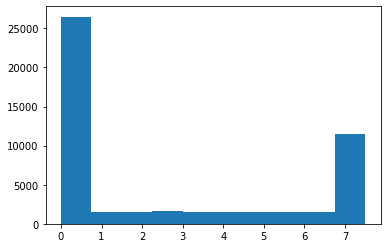

In [18]:
tmp = np.linalg.norm(all_distances.reshape(-1) - all_logits.reshape(-1), ord=2) / np.linalg.norm(all_distances)
plt.hist((all_distances - all_logits).numpy().reshape(-1))




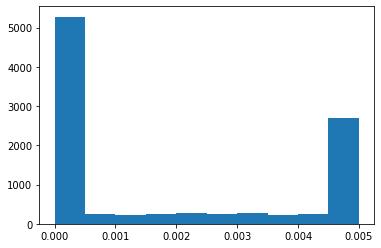

In [50]:
a = plt.hist(all_distances.numpy().reshape(-1))


In [51]:
bins = a[1]
logits = all_logits.numpy()
distances = all_distances.numpy()
rel_errors = [np.mean(np.abs(distances[(distances >= bins[i]) & (distances < bins[i+1])] - logits[(distances >= bins[i]) & (distances < bins[i+1])]) / (distances[(distances >= bins[i]) & (distances < bins[i+1])] + 1)) for i in range(len(bins) - 1)]
errors = [mean_squared_error(distances[(distances >= bins[i]) & (distances < bins[i+1])], logits[(distances >= bins[i]) & (distances < bins[i+1])], squared=False) for i in range(len(bins) - 1)]



In [52]:
errors



[0.0018204137,
 0.0010881317,
 0.00061145844,
 0.00017162679,
 0.00044237345,
 0.0009247826,
 0.0014285297,
 0.0019205724,
 0.0024204834,
 0.0029266553]

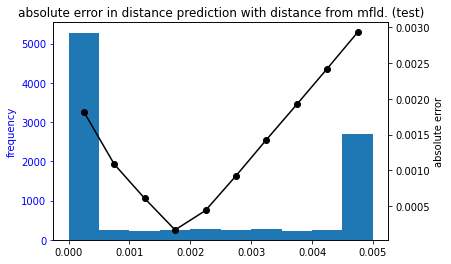

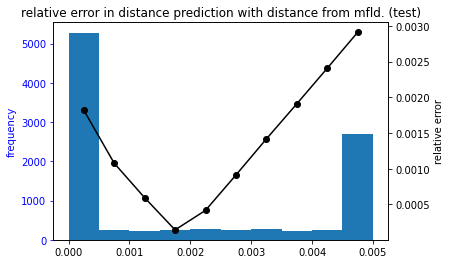

In [53]:
xs = bins.reshape(-1, 1) + np.zeros((bins.shape[0], 30))
ys = np.arange(30).reshape(-1, 1) + np.zeros((30, bins.shape[0]))
fig, ax1 = plt.subplots()
ax1.hist(all_distances.numpy().reshape(-1))
ax1.set_ylabel('frequency', color='b')
ax1.tick_params('y', colors='b')




ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
# ax2.hist(all_distances.numpy().reshape(-1))
ax2.plot([(bins[i] + bins[i+1]) /2 for i in range(len(bins) - 1)], errors, marker="o", color="k")

ax2.set_ylabel('absolute error', color='k')
ax2.tick_params('y', colors='k')

plt.title("absolute error in distance prediction with distance from mfld. (test)")
# plt.plot(xs.T, ys, linestyle="dashed", color="k")
# plt.hist(all_distances.numpy())
plt.show()


xs = bins.reshape(-1, 1) + np.zeros((bins.shape[0], 30))
ys = np.arange(30).reshape(-1, 1) + np.zeros((30, bins.shape[0]))
fig, ax1 = plt.subplots()
ax1.hist(all_distances.numpy().reshape(-1))
ax1.set_ylabel('frequency', color='b')
ax1.tick_params('y', colors='b')




ax2 = ax1.twinx()
# s2 = np.sin(2 * np.pi * t)
# ax2.hist(all_distances.numpy().reshape(-1))
ax2.plot([(bins[i] + bins[i+1]) /2 for i in range(len(bins) - 1)], rel_errors, marker="o", color="k")

ax2.set_ylabel('relative error', color='k')
ax2.tick_params('y', colors='k')

plt.title("relative error in distance prediction with distance from mfld. (test)")
# plt.plot(xs.T, ys, linestyle="dashed", color="k")
# plt.hist(all_distances.numpy())
plt.show()

In [83]:
mean_squared_error(all_distances.numpy().reshape(-1), all_logits.numpy().reshape(-1))



10.043258

(array([50000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([0.0e+00, 5.0e-05, 1.0e-04, 1.5e-04, 2.0e-04, 2.5e-04, 3.0e-04,
        3.5e-04, 4.0e-04, 4.5e-04, 5.0e-04], dtype=float32),
 <BarContainer object of 10 artists>)

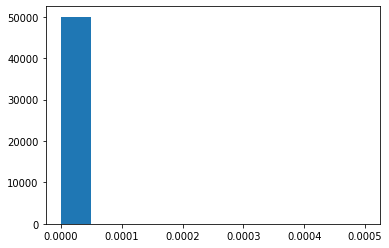

In [22]:
plt.hist(all_logits.numpy().reshape(-1), range=(0,0.0005))

In [23]:
all_logits.numpy().reshape(-1)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [51]:
errors = [mean_squared_error(distances[(distances >= bins[i]) & (distances < bins[i+1])], logits[(distances >= bins[i]) & (distances < bins[i+1])]) for i in range(len(bins) - 1)]


In [3]:
mlp_w_norm = MLPwithNormalisation(input_size=2, output_size=1, hidden_sizes=[512] * 8, weight_norm=False, use_tanh=True)
mlp_w_norm

MLPwithNormalisation(
  (layers): Sequential(
    (fcn-0): Linear(in_features=2, out_features=512, bias=True)
    (bnn-0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-0): ReLU()
    (fcn-1): Linear(in_features=512, out_features=512, bias=True)
    (bn-1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-1): ReLU()
    (fcn-2): Linear(in_features=512, out_features=512, bias=True)
    (bn-2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-2): ReLU()
    (fcn-3): Linear(in_features=512, out_features=512, bias=True)
    (bn-3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-3): ReLU()
    (fcn-4): Linear(in_features=512, out_features=512, bias=True)
    (bn-4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-4): ReLU()
    (fcn-5): Linear(in_features=512, out_features=512, bias=True)
    (bn-5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu-5): ReLU()
    (fcn-6): Linear(in_features=512, 

In [3]:
def f(a=0, b=0, c=0):
    return a + b + c

In [7]:
f(**{"a": 2, "b": 4}, c=5)

11